# 17. 교차분석

    - 1. 동질성 검정 - 사전 설계
    - 2. 독립성 검정 - 사후 설계

## 설정

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import pingouin as pg
from scipy import stats
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

import statsmodels.stats.api as sms
from statsmodels.compat import lzip

sns.set_theme(style="darkgrid")
plt.rc('font', family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

### 데이터 불러오기 + 데이터 전처리

In [2]:
df = pd.read_csv('./data/15_1.PreCH.csv', encoding = 'cp949')
df.head()

,실험처치,감기발병
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


In [3]:
# 행, 열 개수 세기

df.shape

(100, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   실험처치    100 non-null    int64
 1   감기발병    100 non-null    int64
dtypes: int64(2)
memory usage: 1.7 KB


In [5]:
# 범주형 변수 처리

df['실험처치'].replace({1:'실험군', 2:'대조군'}, inplace = True)
df['실험처치'] = df['실험처치'].astype('category')

df['감기발병'].replace({1:'정상', 2:'감기'}, inplace = True)
df['감기발병'] = df['감기발병'].astype('category')

df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_11068\1481087435.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['실험처치'].replace({1:'실험군', 2:'대조군'}, inplace = True)
C:\Users\user\AppData\Local\Temp\ipykernel_11068\1481087435.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

,실험처치,감기발병
0,실험군,정상
1,실험군,정상
2,실험군,정상
3,실험군,정상
4,실험군,정상


## 1. 동질성 검정

### 1. 분할표

In [6]:
tab = pd.crosstab(df['실험처치'], df['감기발병'])

tab

감기발병,감기,정상
실험처치,,
대조군,38,12
실험군,17,33


In [7]:
# 위치조정

tab = tab.loc[['실험군', '대조군'], :]
tab = tab.loc[:, ['정상', '감기']]

tab

감기발병,정상,감기
실험처치,,
실험군,33,17
대조군,12,38


### 2. 교차 분석

In [8]:
# ch 분석

result = sm.stats.Table(tab)

print(result.table_orig)

감기발병  정상  감기
실험처치        
실험군   33  17
대조군   12  38


In [9]:
# 기댓값

print(result.fittedvalues)

감기발병    정상    감기
실험처치            
실험군   22.5  27.5
대조군   22.5  27.5


In [10]:
# pearson 검정

rslt = result.test_nominal_association()

print(rslt.pvalue)

2.4304960694832012e-05


In [11]:
# 표준화 잔차

result.standardized_resids

# 절댓값이 2 이상이면 차이가 있다 라고 해석.
# 현재 |4|이므로 차이가 있다.

감기발병,정상,감기
실험처치,,
실험군,4.221159,-4.221159
대조군,-4.221159,4.221159


### 3. 상대적 위험률
    - 두 그룹 간의 특정 사건 발생 위험을 비교하는 지표
    - 앞에서는 차이가 있다 없다만 알 수 있음. (연관성)
    - 강도, 방향을 알 수 없음

In [12]:
table = tab.to_numpy()

In [13]:
t22 = sm.stats.Table2x2(table)
print(t22.summary())

               Estimate   SE   LCB   UCB   p-value
--------------------------------------------------
Odds ratio        6.147       2.565 14.729   0.000
Log odds ratio    1.816 0.446 0.942  2.690   0.000
Risk ratio        2.750       1.616  4.681   0.000
Log risk ratio    1.012 0.271 0.480  1.543   0.000
--------------------------------------------------



- Risk ratio : 실험군이 대조군에 비해서 감기에 걸리지 않을 **확률**이 약 2.75배 높다.

사전 설계 = 해당 포지션 / 해당 집단

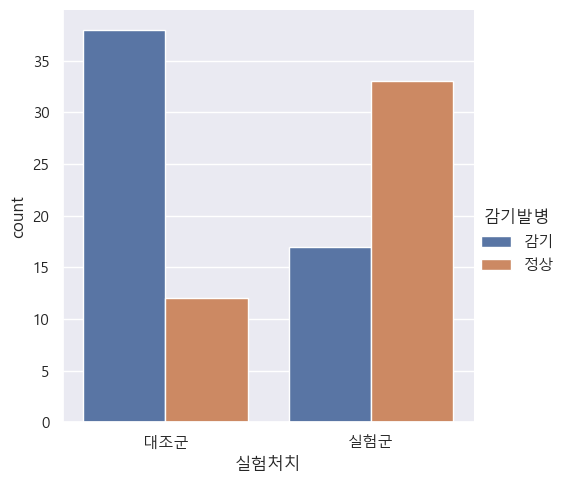

In [17]:
# 그래프
sns.catplot(x = '실험처치',
            hue = '감기발병',
            kind = 'count',
            data = df)

plt.show()

## 2. 독립성 검정

### 데이터 불러오기

In [19]:
df = pd.read_csv('./data/16_1.PostCH.csv', encoding = 'cp949')
df.head(10)

,폐암,흡연,관측치
0,1,1,170867
1,1,2,51690
2,1,3,46598
3,1,4,29178
4,1,5,27784
5,2,1,723
6,2,2,370
7,2,3,497
8,2,4,319
9,2,5,504


In [20]:
# 범주형 변수 처리

df['폐암'].replace({1:'정상', 2:'폐암'}, inplace = True)
df['폐암'] = df['폐암'].astype('category')

df['흡연'].replace({1:'비흡연', 2:'장기금연', 3:'단기금연', 4:'재흡연', 5:'흡연'}, inplace = True)
df['흡연'] = df['흡연'].astype('category')

df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_11068\1366584709.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['폐암'].replace({1:'정상', 2:'폐암'}, inplace = True)
C:\Users\user\AppData\Local\Temp\ipykernel_11068\1366584709.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

,폐암,흡연,관측치
0,정상,비흡연,170867
1,정상,장기금연,51690
2,정상,단기금연,46598
3,정상,재흡연,29178
4,정상,흡연,27784


- 귀무가설 : 흡연 유무와 폐암 유무는 서로 독립적이다.

- 연구가설 : 흡연 유무와 폐암 유무는 서로 독립적이지 않다.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   폐암      10 non-null     category
 1   흡연      10 non-null     category
 2   관측치     10 non-null     int64   
dtypes: category(2), int64(1)
memory usage: 568.0 bytes


### 1. 분할표 만들기

In [ ]:
tab = pd.crosstab(df['폐암'],
                  df['흡연'],
                  values=df['관측치'],
                  aggfunc='sum')

tab

흡연,단기금연,비흡연,장기금연,재흡연,흡연
폐암,,,,,
정상,46598,170867,51690,29178,27784
폐암,497,723,370,319,504


In [25]:
# 위치조정

tab = tab.loc[:, ['비흡연', '장기금연', '단기금연', '재흡연', '흡연']]

tab

흡연,비흡연,장기금연,단기금연,재흡연,흡연
폐암,,,,,
정상,170867,51690,46598,29178,27784
폐암,723,370,497,319,504


In [26]:
result = sm.stats.Table(tab)

In [28]:
rslt = result.test_nominal_association()

print(rslt.pvalue)

0.0


- 독립적이지 않다. 연관이 있다. 귀무가설 기각

### 3. 표준화 잔차

In [30]:
# 표준화 잔차

result.standardized_resids

# 절댓값이 2 이상이면 차이가 있다 라고 해석.
# 현재 |4|이므로 차이가 있다.

흡연,비흡연,장기금연,단기금연,재흡연,흡연
폐암,,,,,
정상,21.978698,0.692265,-8.809885,-7.315323,-21.576857
폐암,-21.978698,-0.692265,8.809885,7.315323,21.576857


In [38]:
# 비흡연과 흡연에서 아주 큰 차이가 있다고 보여지므로 두 개만 뽑아서 확인

tab = tab.loc[:, ['비흡연', '흡연']]

In [34]:
table = np.asarray(tab)

table

array([[170867,  27784],
       [   723,    504]])

In [39]:
t33 = sm.stats.Table2x2(table)

print(t33.summary())

# 사후설계에서는 Odds ratio 를 중요하게 봄. (사전은 Risk)

               Estimate   SE   LCB   UCB  p-value
-------------------------------------------------
Odds ratio        4.287       3.823 4.807   0.000
Log odds ratio    1.456 0.058 1.341 1.570   0.000
Risk ratio        1.460       1.393 1.530   0.000
Log risk ratio    0.378 0.024 0.332 0.425   0.000
-------------------------------------------------


비흡연자에 비해 흡연자가 폐암에 걸릴 오즈비가 약 4.278배 높다.
    
    = 흡연자가 폐암에 걸릴 오즈가 4.278배 높다.


    risk ratio = 흡연자가 비흡연자보다 폐암에 걸릴 확률은 46% 더 높다.

사후 설계 = 해당 포지션 /전체 관측치